## Building a Hangul classifier

In [19]:
import os
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.model_selection import train_test_split
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Currently using {device}")

Currently using cuda


Check how many hangul characters are in the dataset

In [20]:
files = os.listdir('data')
unique_chars = sorted(list(set([filename.split("_")[0] for filename in files])))
print(unique_chars)
print(len(unique_chars))

['a', 'ae', 'b', 'bb', 'ch', 'd', 'e', 'eo', 'eu', 'g', 'gg', 'h', 'i', 'j', 'k', 'm', 'n', 'ng', 'o', 'p', 'r', 's', 'ss', 't', 'u', 'ya', 'yae', 'ye', 'yo', 'yu']
30


## Data Preparation

In [21]:
datas = np.array([cv.imread('data/'+filename, cv.IMREAD_GRAYSCALE).flatten() for filename in sorted(files)]) # image data; sorted in (a -> yu order)
labels = np.array([i for i in range(30) for _ in range(80)]) # class number; there are 80 images per character for 30 total characters

# we assign indexes to each character since the model outputs a number, not characters
# Ex: 0 -> a, 1 -> ae, etc...
classes = dict([(i,char) for i,char in zip([j for j in range(30)], unique_chars)]) 
print(classes)
print(f"Total classes: {len(classes)}")

hangul = {'data': datas, 'label': labels}

{0: 'a', 1: 'ae', 2: 'b', 3: 'bb', 4: 'ch', 5: 'd', 6: 'e', 7: 'eo', 8: 'eu', 9: 'g', 10: 'gg', 11: 'h', 12: 'i', 13: 'j', 14: 'k', 15: 'm', 16: 'n', 17: 'ng', 18: 'o', 19: 'p', 20: 'r', 21: 's', 22: 'ss', 23: 't', 24: 'u', 25: 'ya', 26: 'yae', 27: 'ye', 28: 'yo', 29: 'yu'}
Total classes: 30


### Visualizing the dataset

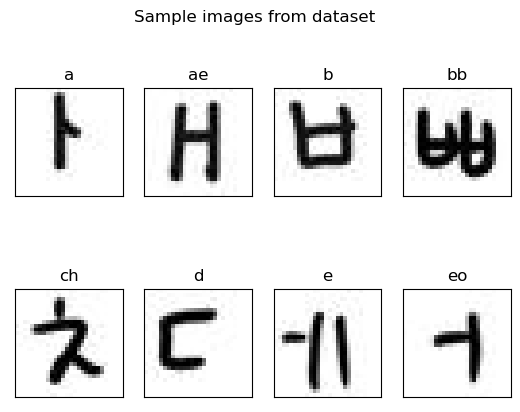

In [22]:
fig, axs = plt.subplots(2,4)
axs = axs.flatten()
for i in range(8):
    axs[i].imshow(hangul['data'][i*80].reshape(28,28), cmap='gray')
    axs[i].set_title(classes[hangul['label'][i*80]])
    axs[i].axes.xaxis.set_visible(False)
    axs[i].axes.yaxis.set_visible(False)
fig.suptitle("Sample images from dataset")
plt.show()

### Split the dataset into training/testing set

In [23]:
X_train, X_test, y_train, y_test = train_test_split(hangul['data'],
                                                    hangul['label'],
                                                    test_size=0.3,
                                                    random_state=42)
X_train = torch.from_numpy(X_train.astype(np.float32)).to(device)
y_train = torch.from_numpy(y_train).to(device)
X_test = torch.from_numpy(X_test.astype(np.float32)).to(device)
y_test = torch.from_numpy(y_test).to(device)

## Implementing a MLP solution

In [24]:
# Define MLP object

class MLP(nn.Module):
    """
    A model that implements a logistic regression classifier. 
    """
    def __init__(self, input_size, num_classes, hidden_sizes):
        """
        Constructor for MLP object

        Args:
            input_size (int): size of input tensor
            num_classes (int): number of classes the model can predict
            hidden_sizes (list): number of neurons in each hidden layer; [100,50] would represent a hidden layer with 100 neurons and another hidden layer with 50 neurons.
        """
        super(MLP, self).__init__()
        # initialize the model weights

        layers = []
        start_size = input_size
        for h_size in (hidden_sizes):
            layers.append(nn.Linear(start_size, h_size))
            layers.append(nn.Sigmoid())
            start_size = h_size

        layers.append(nn.Linear(start_size,num_classes))
        layers.append(nn.Sigmoid())


        self.linear_stack = nn.Sequential(*layers)
        print(self.linear_stack)

    def forward(self, x):
        """
        Forward pass of the model

        Args:
            x (tensor): Input to the model
        
        Returns:
            out (tensor): Output of the model

        """
        out = self.linear_stack(x)
        out = F.softmax(out, dim=1)
        return out


### MLP without batch training

Using cuda
--------------------------------
Sequential(
  (0): Linear(in_features=784, out_features=407, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=407, out_features=30, bias=True)
  (3): Sigmoid()
)


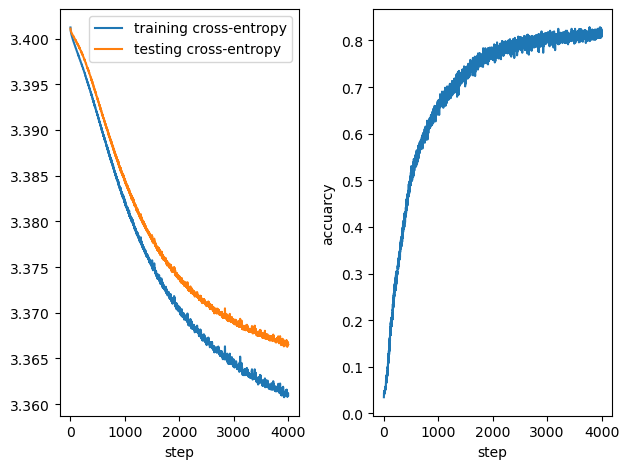

In [36]:
print(f"Using {device}")
print("--------------------------------")

# Image size is 28x28, resulting in 784 inputs; 
model = MLP(input_size = 784, num_classes = 30, hidden_sizes = [(784+30)//2]).to(device)

n_epochs = 4000
learning_rate = 0.5
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)
train_losses = np.zeros((n_epochs,))
test_losses = np.zeros((n_epochs,))
accuracies = np.zeros((n_epochs,))

for epoch in range(n_epochs):
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    train_losses[epoch] = loss.item()

    with torch.no_grad():
        test_outputs = model(X_test)
        test_loss = criterion(test_outputs, y_test)
        test_losses[epoch] = test_loss.item()
        accuracies[epoch] = (torch.sum(test_outputs.argmax(dim=1) == y_test) / y_test.shape[0]).item()
    loss.backward()
    optimizer.step()

plt.figure()
plt.subplot(1,2,1)
plt.plot(range(n_epochs), train_losses, label='training cross-entropy')
plt.plot(range(n_epochs), test_losses, label='testing cross-entropy')
plt.xlabel('step')
plt.legend()

plt.subplot(1,2,2)
plt.plot(range(n_epochs), accuracies)
plt.xlabel('step')
plt.ylabel('accuarcy')
plt.tight_layout()
plt.show()

### MLP with batch training

In [26]:
trainset = torch.utils.data.TensorDataset(X_train, y_train)
trainloader = torch.utils.data.DataLoader(trainset,
                                          batch_size=80,
                                          generator=torch.Generator(device='cpu'),
                                          shuffle=True)

Sequential(
  (0): Linear(in_features=784, out_features=407, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=407, out_features=30, bias=True)
  (3): Sigmoid()
)


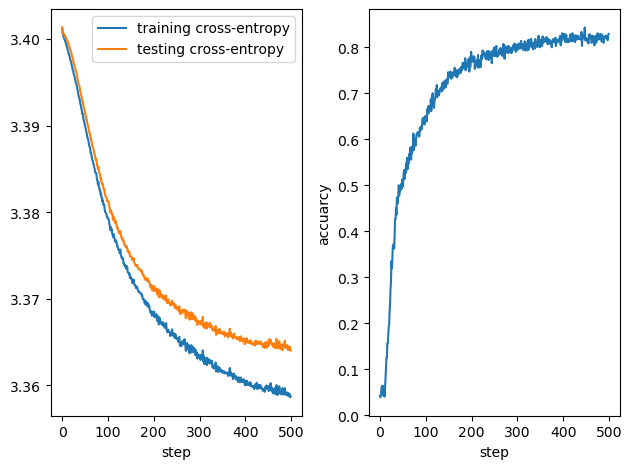

In [33]:
model = MLP(input_size = 784, num_classes = 30, hidden_sizes = [(784+30)//2]).to(device)

n_epochs = 500
learning_rate = 0.3
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)
train_losses = np.zeros((n_epochs,))
test_losses = np.zeros((n_epochs,))
accuracies = np.zeros((n_epochs,))

for epoch in range(n_epochs):

    with torch.no_grad():
        test_outputs = model(X_test)
        test_loss = criterion(test_outputs, y_test)
        test_losses[epoch] = test_loss.item()
        accuracies[epoch] = (torch.sum(test_outputs.argmax(dim=1) == y_test) / y_test.shape[0]).item()

        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        train_losses[epoch] = loss.item()


    for inputs, labels in trainloader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

plt.figure()
plt.subplot(1,2,1)
plt.plot(range(n_epochs), train_losses, label='training cross-entropy')
plt.plot(range(n_epochs), test_losses, label='testing cross-entropy')
plt.xlabel('step')
plt.legend()


plt.subplot(1,2,2)
plt.plot(range(n_epochs), accuracies)
plt.xlabel('step')
plt.ylabel('accuarcy')
plt.tight_layout()
plt.show()

## Convolutional Neural Network (CNN)

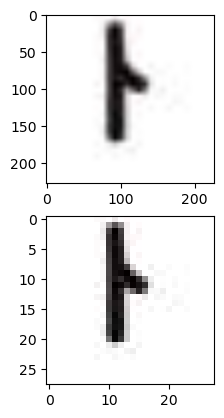

In [30]:
img = cv.imread("data/a_0_0.jpg")

img_res = cv.resize(img, (227,227))

plt.figure()
plt.subplot(2,1,1)
plt.imshow(img_res)
plt.subplot(2,1,2)
plt.imshow(img)
plt.show()